In [1]:
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchdp import PrivacyEngine

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

Warning! Tensorboard library was not found.


In [2]:
class Arguments:
    """Parameters for training"""
    def __init__(self):
        self.epochs = 500
        self.iterations = 1
        self.lr = 0.01
        self.shuffle_dataset = True
        self.batch_size = 8
        self.test_batch_size = 8
        self.log_interval = 10
        self.seed = 1
        self.disable_federated = True
        self.disable_dp = False
        self.alphas=[1.1, 2, 4, 10]
        self.delta = 1.0
        self.workers = 1
        self.disable_verbose_training = True
    

args = Arguments()

torch.manual_seed(args.seed)
kwargs = {}

In [3]:
# separates data and labels and initialises data loaders
def prepare_data(dataset, shuffle_dataset, batch_size, num_workers):

    X = dataset.data
    y = dataset.target

    # Standard train/test split of 0.75/0.25 (see sklearn docs), checks shuffle_dataset flag
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, shuffle=shuffle_dataset)

    # Initialise train_loaders list for storing each worker's train_loader
    train_loaders = list()

    # Split training data equally among all workers
    remote_X_train = list()
    remote_X_train.append(np.array_split(X_train, num_workers))

    # Split training labels equally among all workers
    remote_y_train = list()    
    remote_y_train.append(np.array_split(y_train, num_workers))

    # This looks like it's reinitialising these variables as their index 0 values,
    # but it's actually discarding an unwanted outer object layer so that we can directly 
    # reference the data/target lists.
    remote_X_train = remote_X_train[0]
    remote_y_train = remote_y_train[0]

    # Convert training data & labels into torch tensors, then into datasets, then into dataloaders
    for i in range(len(remote_X_train)):
        remote_X_train[i] = torch.tensor(remote_X_train[i]).float()
        remote_y_train[i] = torch.tensor(remote_y_train[i]).long()
        train = TensorDataset(remote_X_train[i], remote_y_train[i])
        train_loaders.append(DataLoader(train, batch_size=batch_size, shuffle=True))

    # Standard test loader setup as we only need one
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).long()
    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

    return train_loaders, test_loader

In [4]:
# Set up a model, optimiser and renyi privacy engine for each worker (only call if DP is needed)
def prepare_private_training(model, train_loaders, num_workers, batch_size, alphas, lr):
    
    model_pool = list()
    optimizer_pool = list()
    priv_eng_pool = list()

    # We use deepcopy to make wholly independent copies of the shared model
    for _ in range (num_workers):
        model_pool.append(copy.deepcopy(model))

    # We call the SGD constructor each time to ensure model updates are correctly applied
    for model in model_pool:
        opt = optim.SGD(model.parameters(), lr=lr)
        optimizer_pool.append(opt)

    # Attaches privacy engine for each model to each optimiser, effectively replacing
    # gradient calculation functions with similar DP-enabled ones.
    for i in range(len(model_pool)):    
        privacy_engine = PrivacyEngine(
                            model_pool[i],
                            batch_size=batch_size,
                            sample_size=len(train_loaders[i].dataset),
                            alphas=alphas,
                            noise_multiplier = 1.0,
                            max_grad_norm = 1.0)

        privacy_engine.attach(optimizer_pool[i])

    return model_pool, optimizer_pool

In [5]:
# Set up a model and optimiser for each worker (only call if DP is not needed)
def prepare_training(model, train_loaders, num_workers, lr):
    
    model_pool = list()
    optimizer_pool = list()

    # We use deepcopy to make wholly independent copies of the shared model
    for _ in range (num_workers):
        model_pool.append(copy.deepcopy(model))

    # We call the SGD constructor each time to ensure model updates are correctly applied
    for model in model_pool:
        opt = optim.SGD(model.parameters(), lr=lr)
        optimizer_pool.append(opt)

    return model_pool, optimizer_pool

In [6]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 3)
        self.softmax = nn.Softmax(dim=0)
    
    # pass-forward procedure using a relu and a softmax output
    def forward(self, x):
        x = x.view(-1, 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [7]:
# Main model training routine
def train(model, optimizer, train_loader, epoch, i, disable_verbose_training, disable_dp, delta):
    model.train()

    # We will store the cross-entropy loss to report it later    
    losses = []

    # Standard pytorch training loop
    for _batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(data)
        loss = F.cross_entropy(pred, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if not disable_verbose_training:
        # If DP is enabled, show our data leakage as we go along with loss output
        if not disable_dp:
            epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)
            print(
                    f"Model ID: {i:2d}   "
                    f"Train Epoch: {epoch:2d}   "
                    f"Loss: {np.mean(losses):.6f} "
                    f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
            )
        else:
            # If we are not using DP, just show the loss output 
            print(f"Model ID: {i:2d}   Train Epoch: {epoch:2d}   Loss: {np.mean(losses):.6f}")

In [8]:
# When all workers have trained their local models, bring models together and average them
def aggregate_models(models):

    params = list()
    num_workers = len(models)

    # Deep copying the model parameters directly makes them easier to work with
    for model_id in range(num_workers):
        params.append(list(copy.deepcopy(models[model_id]).parameters()))

        # Remove outer object layer of each parameter list so we can access it directly
        for layer_id in range(len(params[0])):
            params[model_id][layer_id] = params[model_id][layer_id].data

    agg_params = list()

    # Take the mean average of worker parameters at each model layer
    for layer_id in range(len(params[0])):

        agg_layer = params[0][layer_id]

        for worker_id in range(1, num_workers):
            agg_layer = agg_layer + params[worker_id][layer_id]

        agg_layer = agg_layer / num_workers
        agg_params.append(agg_layer)

    # Initialise new shared model to be used, and access parameters directly
    new_model = Net()
    new_params = list(new_model.parameters())

    # Turn off pytorch autograd and overwrite the new model parameters with the averaged params
    with torch.no_grad():
        for layer_index in range(len(new_params)):
            new_params[layer_index].set_(agg_params[layer_index])

    # This will be our new shared model for testing and further training
    return new_model

In [9]:
# Model Test routine
def test(data_loader, model):

    model.eval()
    test_loss = 0

    # Standard pytorch test loop
    for data, target in data_loader:
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

    # We take the mean of the testing set loss        
    test_loss /= len(data_loader.dataset)

    # We could print the test loss output or just return it.
    # print('Test set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

In [10]:
def select_prepare_training(init_model, train_loaders):
    # Case switch based on whether or not we want to use DP (see the Arguments class)
    if not args.disable_dp:
        models,opts = prepare_private_training(init_model, train_loaders, args.workers, args.batch_size, args.alphas, args.lr)
    else:
        models,opts = prepare_training(init_model, train_loaders, args.workers)
    
    return models,opts

Precision = 0.9210526315789473
Recall = 0.9210526315789473
F1 score = 0.9210526315789473


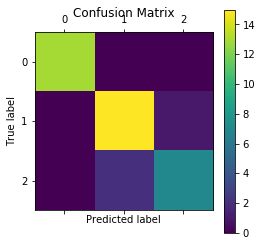

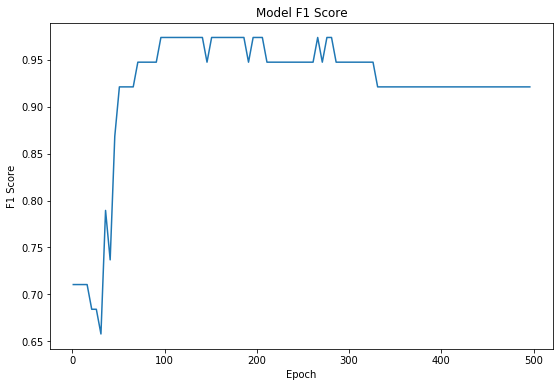

In [11]:
# testing demo function to call all above functions and produce a federated learning model.
init_model = Net()

# Here we're using the Iris dataset - TODO change this for something more challenging
iris = load_iris()
_, X_test, _, y_test = train_test_split(iris.data, iris.target, random_state=0, shuffle=args.shuffle_dataset)
train_loaders, test_loader = prepare_data(iris, args.shuffle_dataset, args.batch_size, args.workers)

f1_scores = list()

# Case switch based on whether or not we want to use DP (see the Arguments class)
models,opts = select_prepare_training(init_model, train_loaders)

# Train all of our worker models on their local data, then combine and aggregate their models
for epoch in range(1,args.epochs+1):
    for i in range(len(models)):
        train(models[i], opts[i], train_loaders[i], epoch, i, args.disable_verbose_training, args.disable_dp, args.delta)
    new_model = aggregate_models(models)
    models,opts = select_prepare_training(new_model, train_loaders)
    
    # Every 5 epochs record the F1 Score of the aggregated model
    if (epoch%5)==0:
        with torch.no_grad():
            y_pred = new_model(torch.tensor(X_test).float())
            y_pred = np.array(y_pred.argmax(1))
            f1_scores.append(f1_score(y_test, y_pred, average='micro'))

# Turn off pytorch autograd to run some scikit learn metrics (Precision, Recall, F1 score)
with torch.no_grad():
    _, X_test, _, y_test = train_test_split(iris.data, iris.target, random_state=0, shuffle=args.shuffle_dataset)
    y_pred = new_model(torch.tensor(X_test).float())
    y_pred = np.array(y_pred.argmax(1))
    print(f"Precision = {precision_score(y_test, y_pred, average='micro')}")
    print(f"Recall = {recall_score(y_test, y_pred, average='micro')}")
    print(f"F1 score = {f1_score(y_test, y_pred, average='micro')}")

    # Create a confusion matrix to see how well we perform on Iris
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Plot graph of F1 Score history over all epochs
    plt.figure(figsize=(9,6))
    plt.plot(range(1,args.epochs+1,5),f1_scores)
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')